<strong>Lie Reubensto</strong> <br>
<strong>Speech & Audio Processing Project 1</strong> <br>
<strong>Run in Google Colab</strong>

## <h2><strong>Cat & Dog Sound Classification (Machine Learning Approach)</strong></h2>

In [ ]:
# Download data
from gdown import download

download("https://drive.google.com/uc?export=download&id=16T1uGEtgFPHMCxl-H1NgaemjtxAVpUoZ", quiet=True)
!mkdir -p input
!unzip -q "Dataset1 dogcat audio.zip" -d input
!rm "Dataset1 dogcat audio.zip"

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import Audio
import sys
import os
os.chdir("/content/input")
sys.path.append(".")
import utils

loaded train_cat with 942.0454375 sec of audio
loaded train_dog with 317.2408125 sec of audio
loaded test_cat with 381.8525 sec of audio
loaded test_dog with 281.1975 sec of audio


In [ ]:
# Load the CSV file
df = pd.read_csv('train_test_split.csv', index_col=0)
df.head()

,test_cat,test_dog,train_cat,train_dog
0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


In [ ]:
# Load the dataset using the load_dataset function from utils.py
dataset = utils.load_dataset(df)

loaded train_cat with 942.0454375 sec of audio
loaded train_dog with 317.2408125 sec of audio
loaded test_cat with 381.8525 sec of audio
loaded test_dog with 281.1975 sec of audio


In [ ]:
# Print the length of each category in the dataset
for key in dataset.keys():
    print(f"{key} has {len(dataset[key])} audio samples")

train_cat has 15072727 audio samples
train_dog has 5075853 audio samples
test_cat has 6109640 audio samples
test_dog has 4499160 audio samples


In [ ]:
yc, src = librosa.load('./cats_dogs/cat_100.wav')
Audio(data=yc, rate=src)

In [ ]:
yd, srd = librosa.load('./cats_dogs/dog_barking_10.wav')
Audio(data=yd, rate=srd)

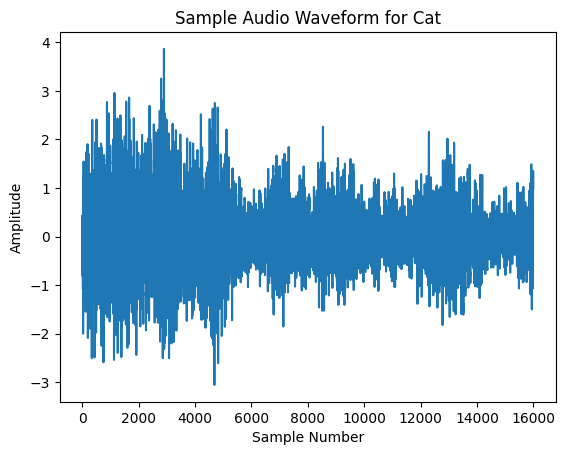

In [ ]:
# Plot the first audio sample for 'train_cat'
sample_cat = dataset['train_cat'][:16000]
plt.plot(sample_cat)
plt.title("Sample Audio Waveform for Cat")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

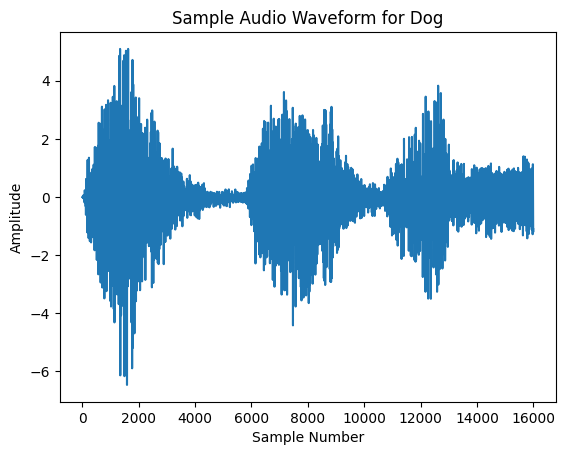

In [ ]:
# Plot the first audio sample for 'train_dog'
sample_dog = dataset['train_dog'][:16000]
plt.plot(sample_dog)
plt.title("Sample Audio Waveform for Dog")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

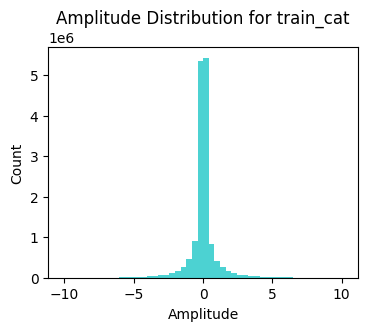

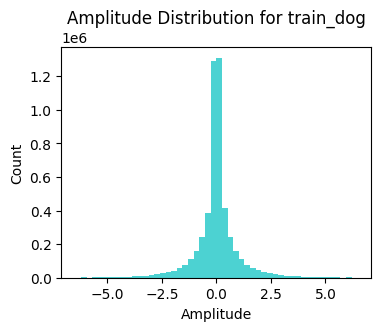

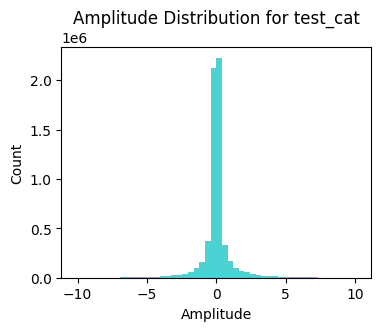

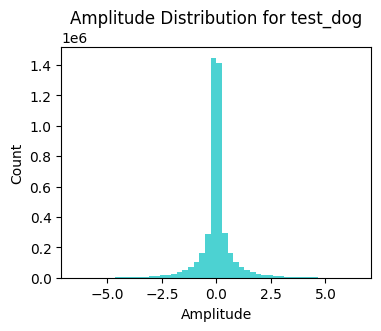

In [ ]:
# Plot histogram for each category's audio sample amplitudes
for key, samples in dataset.items():
    plt.figure(figsize=(4, 3))
    plt.hist(samples, bins=50, alpha=0.7, color='c')
    plt.title(f'Amplitude Distribution for {key}')
    plt.xlabel('Amplitude')
    plt.ylabel('Count')
    plt.show()

In [ ]:
# Check samples duration
sample_rate = 44100
for key, samples in dataset.items():
    duration = len(samples) / sample_rate
    print(f"Duration of {key}: {duration} seconds")

Duration of train_cat: 341.7851927437642 seconds
Duration of train_dog: 115.09870748299319 seconds
Duration of test_cat: 138.540589569161 seconds
Duration of test_dog: 102.02176870748299 seconds


In [ ]:
# Check signal-to-noise ratio (snr)
def compute_snr(samples):
    signal_power = np.mean(samples ** 2)
    noise_power = np.var(samples)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

for key, samples in dataset.items():
    snr_value = compute_snr(samples)
    print(f"SNR for {key}: {snr_value} dB")

SNR for train_cat: 0.0 dB
SNR for train_dog: 0.0 dB
SNR for test_cat: 0.0031848769867792726 dB
SNR for test_dog: 0.00010147181455977261 dB


In [ ]:
# Check zero-crossing rate (zcr)
def zero_crossing_rate(samples):
    zero_crossings = np.where(np.diff(np.sign(samples)))[0]
    return len(zero_crossings) / len(samples)

for key, samples in dataset.items():
    zcr = zero_crossing_rate(samples)
    print(f"ZCR for {key}: {zcr}")

ZCR for train_cat: 0.12397205893797453
ZCR for train_dog: 0.10058013894413412
ZCR for test_cat: 0.12729833509011987
ZCR for test_dog: 0.09150374736617502


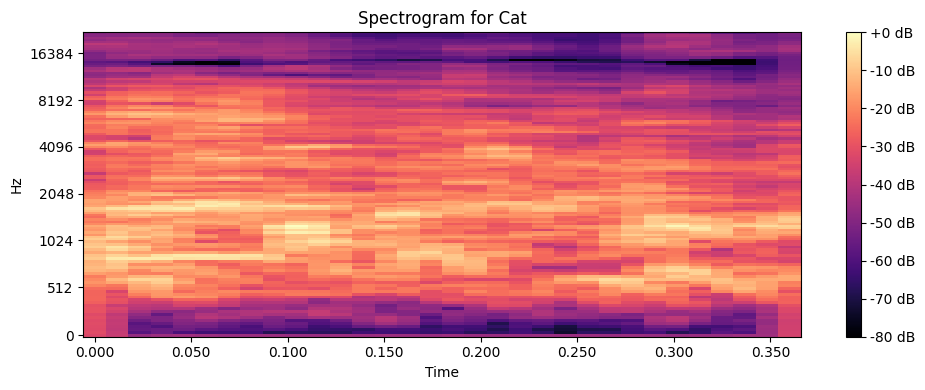

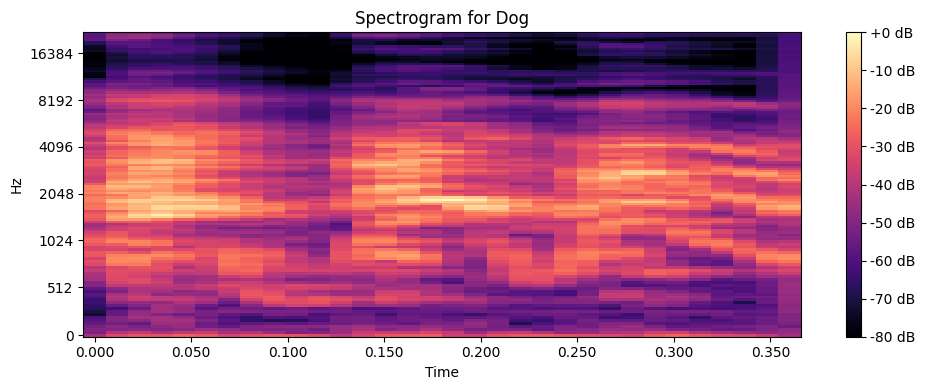

In [ ]:
# Check spectrogram
def plot_spectrogram(samples, title):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=samples, sr=44100)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=44100, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_spectrogram(dataset['train_cat'][:16000], "Spectrogram for Cat")
plot_spectrogram(dataset['train_dog'][:16000], "Spectrogram for Dog")

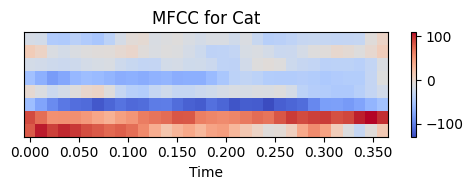

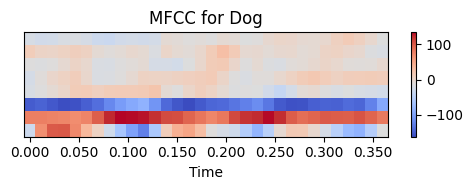

In [ ]:
# Check MFCCs
def plot_mfcc(samples, title):
    mfccs = librosa.feature.mfcc(y=samples, sr=44100, n_mfcc=8)
    plt.figure(figsize=(5, 2))
    librosa.display.specshow(mfccs, sr=44100, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_mfcc(dataset['train_cat'][:16000], "MFCC for Cat")
plot_mfcc(dataset['train_dog'][:16000], "MFCC for Dog")

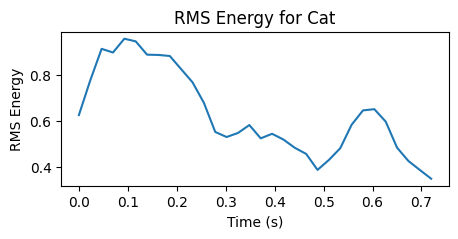

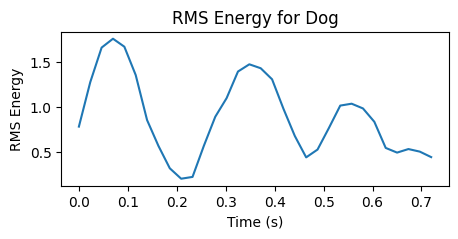

In [ ]:
# Check Root Mean Square (RMS) energy
def plot_rms_energy(samples, title):
    frame_length = 2048
    hop_length = 512
    rms = librosa.feature.rms(y=samples, frame_length=frame_length, hop_length=hop_length)[0]
    frames = range(len(rms))
    t = librosa.frames_to_time(frames, hop_length=hop_length)
    plt.figure(figsize=(5, 2))
    plt.plot(t, rms, label='RMS Energy')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Energy')
    plt.show()

plot_rms_energy(dataset['train_cat'][:16000], "RMS Energy for Cat")
plot_rms_energy(dataset['train_dog'][:16000], "RMS Energy for Dog")

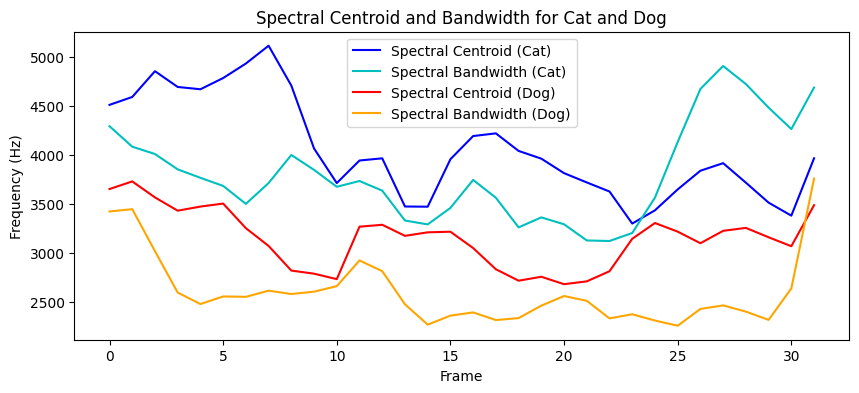

In [ ]:
# Check spectral centroid and bandwidth
def spectral_features(samples, sr):
    centroid = librosa.feature.spectral_centroid(y=samples, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sr)
    return centroid, bandwidth

centroid_cat, bandwidth_cat = spectral_features(dataset['train_cat'][:16000], 44100)
centroid_dog, bandwidth_dog = spectral_features(dataset['train_dog'][:16000], 44100)

plt.figure(figsize=(10, 4))
plt.plot(centroid_cat[0], label='Spectral Centroid (Cat)', color='b')
plt.plot(bandwidth_cat[0], label='Spectral Bandwidth (Cat)', color='c')
plt.plot(centroid_dog[0], label='Spectral Centroid (Dog)', color='r')
plt.plot(bandwidth_dog[0], label='Spectral Bandwidth (Dog)', color='orange')
plt.title("Spectral Centroid and Bandwidth for Cat and Dog")
plt.xlabel("Frame")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.show()

In [ ]:
# Path to the actual data that will be used to train and test the models here
train_cat_dir = '/content/input/cats_dogs/train/cat/'
train_dog_dir = '/content/input/cats_dogs/train/dog/'
test_cat_dir = '/content/input/cats_dogs/test/cats/'
test_dog_dir = '/content/input/cats_dogs/test/test/'

# Helper function to extract features
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    features = {
        'mean_amplitude': np.mean(y),
        'rms_energy': np.mean(librosa.feature.rms(y=y)),
        'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y=y)),
        'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'mfccs_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1),
        'fundamental_freq': librosa.yin(y=y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')).mean()
    }
    return features

# Extract features for all files in a folder
def process_folder(path):
    features_list = []
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        if file_name.endswith('.wav'):
            features = extract_features(file_path)
            features['file_name'] = file_name
            features_list.append(features)
    return pd.DataFrame(features_list)

# Process each class folder
cat_features_train = process_folder(train_cat_dir)
dog_features_train = process_folder(train_dog_dir)
cat_features_test = process_folder(test_cat_dir)
dog_features_test = process_folder(test_dog_dir)

# Add a label column for each df (0: Cat, 1: Dog)
cat_features_train['label'] = 0
cat_features_test['label'] = 0
dog_features_train['label'] = 1
dog_features_test['label'] = 1

# Combine data into one df
features_df_train = pd.concat([cat_features_train, dog_features_train], ignore_index=True)
features_df_test = pd.concat([cat_features_test, dog_features_test], ignore_index=True)

# Display the first few rows of the features_df
features_df_train.head()

,mean_amplitude,rms_energy,zero_crossing_rate,spectral_centroid,spectral_bandwidth,mfccs_mean,fundamental_freq,file_name,label
0,0.004741,0.093703,0.065661,1423.152893,1675.857885,"[-292.629, 100.745224, -29.64082, 31.76359, -6...",708.261846,cat_142.wav,0
1,-0.000395,0.127937,0.176197,2377.854832,1578.414809,"[-268.96396, 66.07921, -47.05818, 77.79, -9.19...",625.371911,cat_124.wav,0
2,-0.000510,0.064882,0.112285,1916.290756,1710.462606,"[-260.47742, 90.3146, -41.42015, 0.4818552, -2...",282.959723,cat_101.wav,0
3,0.000053,0.142259,0.100558,1525.863722,993.089985,"[-219.3369, 143.23264, -104.01589, -4.92377, -...",482.981579,cat_120.wav,0
4,0.000481,0.029198,0.146903,2505.001970,2136.231734,"[-310.7959, 86.92116, -28.689148, 67.26197, -3...",778.410408,cat_150.wav,0


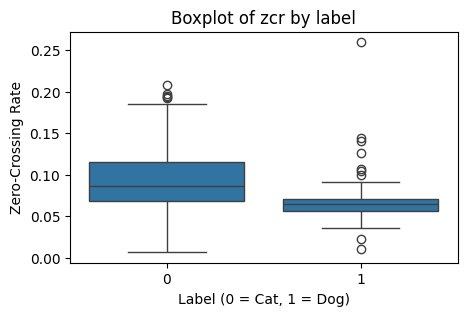


Original dataset size: 210
Filtered dataset size: 194


In [ ]:
# Boxplot for zcr
plt.figure(figsize=(5, 3))
sns.boxplot(data=features_df_train, x='label', y='zero_crossing_rate')
plt.title("Boxplot of zcr by label")
plt.xlabel("Label (0 = Cat, 1 = Dog)")
plt.ylabel("Zero-Crossing Rate")
plt.show()

# Remove Outlier
Q1 = features_df_train['zero_crossing_rate'].quantile(0.25)
Q3 = features_df_train['zero_crossing_rate'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows with ZCR outside the defined bounds
print("\nOriginal dataset size:", features_df_train.shape[0])
features_df_train = features_df_train[(features_df_train['zero_crossing_rate'] >= lower_bound) & (features_df_train['zero_crossing_rate'] <= upper_bound)]
print("Filtered dataset size:", features_df_train.shape[0])

In [ ]:
# Flatten the MFCCs and add each coefficient as a separate column
mfcc_columns = [f'mfcc_{i+1}' for i in range(8)]
for i, col in enumerate(mfcc_columns):
    features_df_train[col] = features_df_train['mfccs_mean'].apply(lambda x: x[i] if len(x) > i else None)
    features_df_test[col] = features_df_test['mfccs_mean'].apply(lambda x: x[i] if len(x) > i else None)

# Drop the original 'mfccs_mean' column and file_name column
features_df_train1 = features_df_train.drop(columns=['mfccs_mean', 'file_name'])
features_df_test1 = features_df_test.drop(columns=['mfccs_mean', 'file_name'])

# Group by label (cat or dog) and calculate the median for each feature
median_features = features_df_train1.groupby('label').median()

# Print out the median feature values for cats and dogs
print("Median feature values:")
median_features

Median feature values:


,mean_amplitude,rms_energy,zero_crossing_rate,spectral_centroid,spectral_bandwidth,fundamental_freq,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8
label,,,,,,,,,,,,,,
0,-0.000026,0.060715,0.083190,1548.624974,1649.097231,360.489185,-291.630371,110.602043,-26.861107,31.510054,-12.025683,21.425035,-7.354985,12.385757
1,-0.000130,0.088467,0.064554,1015.761371,952.283863,346.513694,-311.921082,136.474762,-24.189337,-27.212982,-15.072032,-9.094593,-12.484896,-5.118929


In [ ]:
# Select relevant features
selected_features_train = features_df_train[['spectral_centroid', 'spectral_bandwidth', 'fundamental_freq', 'mfcc_4', 'mfcc_6']]
selected_features_test = features_df_test[['spectral_centroid', 'spectral_bandwidth', 'fundamental_freq', 'mfcc_4', 'mfcc_6']]

# Train and test data
X_train = selected_features_train
y_train = features_df_train['label']
X_test = selected_features_test
y_test = features_df_test['label']

# Train base Decision Tree model
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)
y_pred_dt_base = dt_base.predict(X_test)

# Train base Random Forest model
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)

In [ ]:
# Base Decision Tree hyperparams
dt_base.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
# Base Random Forest hyperparams
rf_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Hyperparameter grid for Decision Tree
dt_param_grid = {'max_features': range(2, 5, 1),
                 'max_depth': range(3, 6, 1),
                 'min_samples_leaf': range(3, 7, 1)}

# Hyperparameter grid for Random Forest
rf_param_grid = {'max_features': ['sqrt', 'log2', None],
                 'max_depth': [None, 3, 5, 7, 11],
                 'n_estimators': range(60, 140, 20)}

# Tuning Decision Tree Classifier
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

# Best Decision Tree model after tuning
dt_tuned = dt_grid_search.best_estimator_
y_pred_dt_tuned = dt_tuned.predict(X_test)
print(f"Best Hyperparameter for Decision Tree: {dt_tuned}")

# Tuning Random Forest Classifier
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model after tuning
rf_tuned = rf_grid_search.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test)
print(f"Best Hyperparameter for Random Forest: {rf_tuned}")

Best Hyperparameter for Decision Tree: DecisionTreeClassifier(max_depth=4, max_features=3, min_samples_leaf=4,
                       random_state=42)
Best Hyperparameter for Random Forest: RandomForestClassifier(random_state=42)


In [ ]:
# Evaluation for base Decision Tree model
print("Base Decision Tree:")
print(classification_report(y_test, y_pred_dt_base))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_dt_base))

# Evaluation for tuned Decision Tree model
print("\nTuned Decision Tree:")
print(classification_report(y_test, y_pred_dt_tuned))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_dt_tuned))

Base Decision Tree:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.81      0.79      0.80        28

    accuracy                           0.84        67
   macro avg       0.83      0.83      0.83        67
weighted avg       0.84      0.84      0.84        67

Confusion Matrix
[[34  5]
 [ 6 22]]

Tuned Decision Tree:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        39
           1       0.88      0.79      0.83        28

    accuracy                           0.87        67
   macro avg       0.87      0.85      0.86        67
weighted avg       0.87      0.87      0.86        67

Confusion Matrix
[[36  3]
 [ 6 22]]


In [ ]:
y1, sr1 = librosa.load('./cats_dogs/cat_10.wav')
Audio(data=y1, rate=sr1)

In [ ]:
y2, sr2 = librosa.load('./cats_dogs/dog_barking_1.wav')
Audio(data=y2, rate=sr2)

In [ ]:
# Evaluation for base Random Forest model
print("\nBase Random Forest:")
print(classification_report(y_test, y_pred_rf_base))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_rf_base))

# Evaluation for tuned Random Forest model
print("\nTuned Random Forest:")
print(classification_report(y_test, y_pred_rf_tuned))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_rf_tuned))


Base Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        39
           1       0.92      0.86      0.89        28

    accuracy                           0.91        67
   macro avg       0.91      0.90      0.91        67
weighted avg       0.91      0.91      0.91        67

Confusion Matrix
[[37  2]
 [ 4 24]]

Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        39
           1       0.92      0.86      0.89        28

    accuracy                           0.91        67
   macro avg       0.91      0.90      0.91        67
weighted avg       0.91      0.91      0.91        67

Confusion Matrix
[[37  2]
 [ 4 24]]


In [ ]:
# Testing
def process_file(path):
    features_list = []
    if path.endswith('.wav'):
        features = extract_features(path)
        features['file_name'] = path
        features_list.append(features)
    return pd.DataFrame(features_list)

features_for_testing = process_file('./cats_dogs/cat_10.wav')

mfcc_columns = [f'mfcc_{i+1}' for i in range(8)]
for i, col in enumerate(mfcc_columns):
    features_for_testing[col] = features_df_train['mfccs_mean'].apply(lambda x: x[i] if len(x) > i else None)

for_testing = features_for_testing[['spectral_centroid', 'spectral_bandwidth', 'fundamental_freq', 'mfcc_4', 'mfcc_6']]

# 0: Cat, 1: Dog
res_dt_base, res_rf_base, res_dt_tuned, res_rf_tuned = None, None, None, None
res_dt_base = dt_base.predict(for_testing)
res_rf_base = rf_base.predict(for_testing)
res_dt_tuned = dt_tuned.predict(for_testing)
res_rf_tuned = rf_tuned.predict(for_testing)
print(f"dt base says: {res_dt_base}\nrf base says: {res_rf_base}\ndt tuned says: {res_dt_tuned}\n rf tuned says: {res_rf_tuned}")

dt base says: [0]
rf base says: [0]
dt tuned says: [0]
 rf tuned says: [0]


In [ ]:
features_for_testing = process_file('./cats_dogs/dog_barking_1.wav')

mfcc_columns = [f'mfcc_{i+1}' for i in range(8)]
for i, col in enumerate(mfcc_columns):
    features_for_testing[col] = features_df_train['mfccs_mean'].apply(lambda x: x[i] if len(x) > i else None)

for_testing = features_for_testing[['spectral_centroid', 'spectral_bandwidth', 'fundamental_freq', 'mfcc_4', 'mfcc_6']]

# 0: Cat, 1: Dog
res_dt_base, res_rf_base, res_dt_tuned, res_rf_tuned = None, None, None, None
res_dt_base = dt_base.predict(for_testing)
res_rf_base = rf_base.predict(for_testing)
res_dt_tuned = dt_tuned.predict(for_testing)
res_rf_tuned = rf_tuned.predict(for_testing)
print(f"dt base says: {res_dt_base}\nrf base says: {res_rf_base}\ndt tuned says: {res_dt_tuned}\n rf tuned says: {res_rf_tuned}")

dt base says: [0]
rf base says: [0]
dt tuned says: [0]
 rf tuned says: [0]


## <h2><strong>Cough Audio Classification (Deep Learning Approach)</strong></h2>

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 40)
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score
import copy
import sys
import random
import os
os.chdir("/content")
sys.path.append(".")

In [ ]:
# Download data
from gdown import download

download("https://drive.google.com/uc?export=download&id=1acT-syyiK6PI7h43i7-o8rgukYTf_jQj", quiet=True)
!mkdir -p data2
!unzip -q "Dataset2 Covid19 Cough.zip" -d data2
!rm "Dataset2 Covid19 Cough.zip"

In [ ]:
# Load metadata CSV
metadata_path = './data2/metadata_compiled.csv'
metadata = pd.read_csv(metadata_path)
metadata.head()

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,...,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop rows that have missing values in status column
metadata_v1 = metadata.dropna(subset=['status'])

# Filter for supported audio file types (OGG and WEBM)
audio_folder = './data2/'
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(('.ogg', '.webm'))]

print("Total Number of audio files found:", len(audio_files))
print("Number of uuid with status not null:", len(metadata_v1['uuid'])) # Remaining data to be used (still depends later if the audio is actually available or not)
metadata_v1.head()

Total Number of audio files found: 27550
Number of uuid with status not null: 16224


,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,...,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,13.146502,NaN,NaN,21.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,001d8e33-a4af-4edb-98ba-b03f891d9a6c,2020-05-13T01:27:42.552773+00:00,0.0306,12.713480,13.8,-89.6,NaN,female,False,True,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check the classes / status
metadata_v1['status'].unique()

array(['healthy', 'COVID-19', 'symptomatic'], dtype=object)

In [ ]:
# Filter mostly not used and empty columns
metadata_v2 = metadata_v1[['uuid', 'status']]
metadata_v2.head()

,uuid,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,healthy
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,healthy
7,001d8e33-a4af-4edb-98ba-b03f891d9a6c,COVID-19


In [ ]:
# Check count of each status
metadata_v2['status'].value_counts()

,count
status,
healthy,12479
symptomatic,2590
COVID-19,1155


In [ ]:
# Undersampling
# Group the data by class
healthy_samples = metadata_v2[metadata_v2['status'] == 'healthy'].sample(n=len(metadata_v2[metadata_v2['status']=="COVID-19"]), random_state=42)
symptomatic_samples = metadata_v2[metadata_v2['status'] == 'symptomatic'].sample(n=len(metadata_v2[metadata_v2['status']=="COVID-19"]), random_state=42)
covid_samples = metadata_v2[metadata_v2['status'] == 'COVID-19']

# Concatenate the undersampled data
metadata_v2_1 = pd.concat([healthy_samples, symptomatic_samples, covid_samples]).reset_index(drop=True)

# Shuffle the dataset to mix classes
metadata_v2_1 = metadata_v2_1.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Checkpoint
metadata_v3 = metadata_v2_1.copy()

In [ ]:
# Check count of each status
metadata_v3['status'].value_counts()

,count
status,
COVID-19,1155
healthy,1155
symptomatic,1155


In [ ]:
# Relocate audio files
use_audio_folder = './data2/use/'
os.makedirs(use_audio_folder, exist_ok=True)

for file in audio_files:
  if os.path.splitext(file)[0] in metadata_v3["uuid"].values:
    source_path = os.path.join(audio_folder, file)
    destination_path = os.path.join(use_audio_folder, file)
    shutil.move(source_path, destination_path)

In [ ]:
# Find the biggest sample rate
biggest_sr = 0

for idx, row in tqdm(metadata_v3.iterrows(), total=len(metadata_v3)):
  file_path = os.path.join(use_audio_folder, f"{row['uuid']}.ogg") if os.path.exists(os.path.join(use_audio_folder, f"{row['uuid']}.ogg")) else os.path.join(use_audio_folder, f"{row['uuid']}.webm")

  if os.path.exists(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate >= biggest_sr:
      biggest_sr = sample_rate

print(f"\n{biggest_sr}")

100%|██████████| 3465/3465 [01:02<00:00, 55.18it/s]


48000


In [ ]:
# Parameters for MFCC extraction
target_sample_rate = biggest_sr
target_duration = 8  # seconds
num_mfcc = 8
window_fn = torch.blackman_window
n_mels = 32

metadata_v3["mfcc"] = None

# Load, resample, zero padding, and extract MFCCs, and save in dataframe
for idx, row in tqdm(metadata_v3.iterrows(), total=len(metadata_v3)):
  file_path = os.path.join(use_audio_folder, f"{row['uuid']}.ogg") if os.path.exists(os.path.join(use_audio_folder, f"{row['uuid']}.ogg")) else os.path.join(use_audio_folder, f"{row['uuid']}.webm")

  if os.path.exists(file_path):
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample (if needed)
    if sample_rate != target_sample_rate:
      resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
      waveform = resampler(waveform)

    # Zero padding
    num_samples = target_sample_rate * target_duration
    waveform = torch.nn.functional.pad(waveform, (0, max(0, num_samples - waveform.size(1))))

    # MFCC transformation
    mfcc_transform = torchaudio.transforms.MFCC(sample_rate=target_sample_rate,
                                                n_mfcc=num_mfcc,
                                                melkwargs={"window_fn": window_fn, "n_mels": n_mels})

    mfcc = mfcc_transform(waveform)
    metadata_v3.at[idx, "mfcc"] = mfcc

metadata_v3 = metadata_v3.dropna(subset=['mfcc']).reset_index(drop=True)

100%|██████████| 3465/3465 [02:16<00:00, 25.42it/s]


In [ ]:
# Check mfcc column
metadata_v3.loc[:,['uuid', 'status', 'mfcc']].head()

,uuid,status,mfcc
0,a664172f-6df4-44db-bfd4-c735f1edc3e6,COVID-19,"[[[tensor(-258.3236), tensor(-258.3236), tenso..."
1,07c91673-7815-4a45-b926-47f260fc44ef,healthy,"[[[tensor(-267.9235), tensor(-267.9235), tenso..."
2,bf876d4d-6278-4daf-ade7-0b26e4596bfe,COVID-19,"[[[tensor(-275.1198), tensor(-275.1198), tenso..."
3,38b6365d-b414-4a01-a067-5900f5ccfb3d,symptomatic,"[[[tensor(-366.2676), tensor(-366.2676), tenso..."
4,ceff681b-711e-4e49-ab4a-93d68c99e9cf,symptomatic,"[[[tensor(-246.4258), tensor(-246.4258), tenso..."


In [ ]:
# Resize each MFCC to 150x150 and make it Grayscale
resize_transform = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize((150, 150)), transforms.ToTensor()])
metadata_v3["resized_mfccs"] = metadata_v3["mfcc"].apply(lambda x: resize_transform(x) if x is not None else None)
metadata_v3 = metadata_v3.dropna(subset=['resized_mfccs']).reset_index(drop=True)

# Split into train, validation, and test sets (80%, 10%, 10%)
train_data, temp_data = train_test_split(metadata_v3.loc[:, ['resized_mfccs', 'status']], test_size=0.2, random_state=42, stratify=metadata_v3['status'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['status'])

print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")
print(f"Test data: {len(test_data)} samples")

Training data: 2772 samples
Validation data: 346 samples
Test data: 347 samples


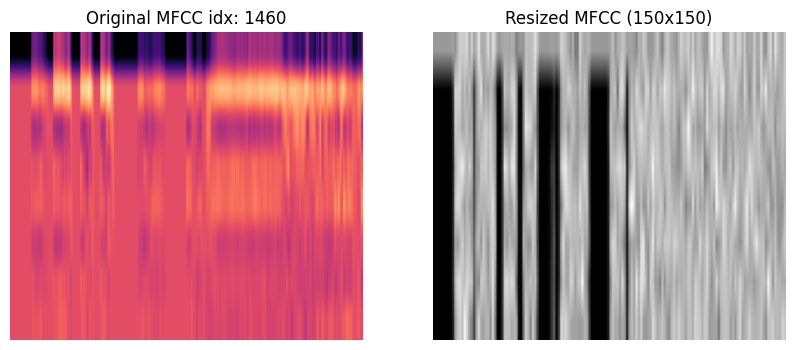

In [ ]:
# Pick one sample from the df
sample_index = random.randint(0, len(metadata_v3)+1)
original_mfcc = metadata_v3.iloc[sample_index]["mfcc"]
resized_mfcc = metadata_v3.iloc[sample_index]["resized_mfccs"]

# Plot original and resized MFCC
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot original
axes[0].imshow(original_mfcc.squeeze().numpy(), cmap='magma', aspect='auto')
axes[0].set_title(f"Original MFCC idx: {sample_index}")
axes[0].axis("off")

# Plot resized version
axes[1].imshow(resized_mfcc.squeeze().numpy(), cmap='gray', aspect='auto')
axes[1].set_title("Resized MFCC (150x150)")
axes[1].axis("off")

plt.show()

In [ ]:
# Base model
class CoughAudioCNN(nn.Module):
  def __init__(self):
    super(CoughAudioCNN, self).__init__()

    # Convolutional Layer 1
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)

    # Max Pooling
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

    # Convolutional Layer 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)

    # Fully Connected Layers
    self.fc1 = nn.Linear(64 * 38 * 38, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    # Convolutional Layer 1
    x = self.pool(F.relu(self.conv1(x)))  # Output size: (150x150x32) -> (75x75x32)

    # Convolutional Layer 2
    x = self.pool(F.relu(self.conv2(x)))  # Output size: (75x75x64) -> (38x38x64)

    # Flatten
    x = torch.flatten(x, 1)

    # Fully Connected Layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    # Classification Head
    x = self.fc3(x)

    return x

# Summary of the base model
print(CoughAudioCNN())

CoughAudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=92416, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
# Encode the 'status' column in each split
le = LabelEncoder()
train_data["status"] = le.fit_transform(train_data["status"])
val_data["status"] = le.transform(val_data["status"])
test_data["status"] = le.transform(test_data["status"])
print("Classes:", le.classes_)

# Separate features and labels for each split
train_input = train_data["resized_mfccs"].tolist()
train_label = train_data["status"].tolist()

val_input = val_data["resized_mfccs"].tolist()
val_label = val_data["status"].tolist()

test_input = test_data["resized_mfccs"].tolist()
test_label = test_data["status"].tolist()

# Convert lists to tensors
train_inputs_tensor = torch.stack(train_input)
train_labels_tensor = torch.tensor(train_label, dtype=torch.long)

val_inputs_tensor = torch.stack(val_input)
val_labels_tensor = torch.tensor(val_label, dtype=torch.long)

test_inputs_tensor = torch.stack(test_input)
test_labels_tensor = torch.tensor(test_label, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_inputs_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_inputs_tensor, test_labels_tensor)

# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

Classes: ['COVID-19' 'healthy' 'symptomatic']


In [ ]:
# Define training parameters
num_epochs = 3
learning_rate = 1e-3

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoughAudioCNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  train_loss = 0
  train_accuracy = 0

  # Loop through each batch
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Track loss and accuracy
    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  # Calculate average loss and accuracy for the epoch
  train_loss = running_loss / len(train_loader)
  train_accuracy = 100. * correct / total

  # Print training statistics
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

  # Validation Phase
  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0
  val_accuracy = 0

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = outputs.max(1)
      val_total += labels.size(0)
      val_correct += predicted.eq(labels).sum().item()

  val_loss /= len(val_loader)
  val_accuracy = 100. * val_correct / val_total
  print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

100%|██████████| 87/87 [00:03<00:00, 24.92it/s]


Epoch [1/3], Loss: 1.1106, Accuracy: 32.83%
Validation Loss: 1.0993, Validation Accuracy: 33.53%



100%|██████████| 87/87 [00:02<00:00, 43.43it/s]


Epoch [2/3], Loss: 1.0992, Accuracy: 33.33%
Validation Loss: 1.0988, Validation Accuracy: 33.53%



100%|██████████| 87/87 [00:01<00:00, 43.53it/s]


Epoch [3/3], Loss: 1.0989, Accuracy: 33.33%
Validation Loss: 1.0986, Validation Accuracy: 33.53%



In [ ]:
# Modified model
class ModifiedCoughAudioCNN(nn.Module):
  def __init__(self):
    super(ModifiedCoughAudioCNN, self).__init__()

    # Convolutional Layer 1
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11)
    self.bn1 = nn.BatchNorm2d(64)

    # Convolutional Layer 2
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7)
    self.bn2 = nn.BatchNorm2d(128)

    # Convolutional Layer 3
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
    self.bn3 = nn.BatchNorm2d(256)

    # Max Pooling and Dropout
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
    self.dropout = nn.Dropout(0.5)

    # Fully Connected Layers
    self.fc1 = nn.Linear(256 * 14 * 14, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    # Convolutional Layer 1
    x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: (140x140x64) -> (70x70x64)

    # Convolutional Layer 2
    x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: (64x64x128) -> (32x32x128)

    # Convolutional Layer 3
    x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Output: (28x28x256) -> (14x14x256)

    # Flatten
    x = torch.flatten(x, 1)

    # Fully Connected Layers
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)

    # Classification Head
    x = self.fc3(x)

    return x

# Summary of the modified model
print(ModifiedCoughAudioCNN())

ModifiedCoughAudioCNN(
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
# Define hyperparameters to tune
param_grid = {'learning_rate': [1e-4, 1e-3],
              'optimizer': ['Adam', 'AdamW'],
              'dropout_rate': [0.3, 0.5],
              'batch_size': [32, 64]}

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_accuracy = 0
best_loss = 999
best_params = {}
best_model_state = None
num_epochs = 3

# Loop over each combination of hyperparameters
for params in ParameterGrid(param_grid):
  # Set up model
  modified_model = ModifiedCoughAudioCNN()
  modified_model.to(device)

  train_loader, val_loader, test_loader = None, None, None
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, params['batch_size'])
  test_loader = torch.utils.data.DataLoader(test_dataset, params['batch_size'])

  # Set up optimizer based on the current parameters
  if params['optimizer'] == 'Adam':
      optimizer = Adam(modified_model.parameters(), lr=params['learning_rate'])
  elif params['optimizer'] == 'AdamW':
      optimizer = AdamW(modified_model.parameters(), lr=params['learning_rate'])

  # Update dropout rate
  modified_model.dropout = nn.Dropout(params['dropout_rate'])

  print(f"\no: {params['optimizer']}, batch: {params['batch_size']}, lr: {params['learning_rate']}, d: {params['dropout_rate']} version\n")

  # Training
  for epoch in range(num_epochs):
    modified_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_loss = 0
    train_accuracy = 0

    # Loop through each batch
    for inputs, labels in tqdm(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      # Forward pass
      outputs = modified_model(inputs)
      loss = criterion(outputs, labels)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

      # Track loss and accuracy
      running_loss += loss.item()
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation Phase
    modified_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_accuracy = 0

    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = modified_model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          _, predicted = outputs.max(1)
          val_total += labels.size(0)
          val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    # Update best parameters if current is better
    if val_accuracy >= best_accuracy and val_loss <= best_loss and epoch == num_epochs-1:
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_params = params
        best_model_state = copy.deepcopy(modified_model.state_dict())

print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy}")

# Load the best model state
modified_model = ModifiedCoughAudioCNN()
modified_model.to(device)
modified_model.load_state_dict(best_model_state)
print("Best model restored!")


o: Adam, batch: 32, lr: 0.0001, d: 0.3 version



100%|██████████| 87/87 [00:13<00:00,  6.57it/s]


Epoch [1/3], Loss: 1.1537, Accuracy: 33.08%
Validation Loss: 1.0993, Validation Accuracy: 31.21%



100%|██████████| 87/87 [00:13<00:00,  6.62it/s]


Epoch [2/3], Loss: 1.1137, Accuracy: 35.06%
Validation Loss: 1.1019, Validation Accuracy: 34.39%



100%|██████████| 87/87 [00:13<00:00,  6.58it/s]


Epoch [3/3], Loss: 1.1126, Accuracy: 34.20%
Validation Loss: 1.0981, Validation Accuracy: 36.71%


o: AdamW, batch: 32, lr: 0.0001, d: 0.3 version



100%|██████████| 87/87 [00:13<00:00,  6.48it/s]


Epoch [1/3], Loss: 1.1417, Accuracy: 32.07%
Validation Loss: 1.1013, Validation Accuracy: 32.95%



100%|██████████| 87/87 [00:13<00:00,  6.45it/s]


Epoch [2/3], Loss: 1.1135, Accuracy: 32.90%
Validation Loss: 1.0984, Validation Accuracy: 33.24%



100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch [3/3], Loss: 1.1072, Accuracy: 34.60%
Validation Loss: 1.0986, Validation Accuracy: 33.82%


o: Adam, batch: 32, lr: 0.001, d: 0.3 version



100%|██████████| 87/87 [00:13<00:00,  6.45it/s]


Epoch [1/3], Loss: 1.4480, Accuracy: 32.76%
Validation Loss: 1.0988, Validation Accuracy: 33.24%



100%|██████████| 87/87 [00:13<00:00,  6.48it/s]


Epoch [2/3], Loss: 1.1029, Accuracy: 33.48%
Validation Loss: 1.0987, Validation Accuracy: 33.24%



100%|██████████| 87/87 [00:13<00:00,  6.40it/s]


Epoch [3/3], Loss: 1.1020, Accuracy: 32.68%
Validation Loss: 1.0987, Validation Accuracy: 33.24%


o: AdamW, batch: 32, lr: 0.001, d: 0.3 version



100%|██████████| 87/87 [00:13<00:00,  6.32it/s]


Epoch [1/3], Loss: 1.6197, Accuracy: 33.41%
Validation Loss: 1.0992, Validation Accuracy: 33.53%



100%|██████████| 87/87 [00:13<00:00,  6.38it/s]


Epoch [2/3], Loss: 1.0997, Accuracy: 33.26%
Validation Loss: 1.0989, Validation Accuracy: 33.53%



100%|██████████| 87/87 [00:13<00:00,  6.34it/s]


Epoch [3/3], Loss: 1.1000, Accuracy: 34.05%
Validation Loss: 1.0988, Validation Accuracy: 33.53%


o: Adam, batch: 32, lr: 0.0001, d: 0.5 version



100%|██████████| 87/87 [00:13<00:00,  6.28it/s]


Epoch [1/3], Loss: 1.2159, Accuracy: 33.51%
Validation Loss: 1.0991, Validation Accuracy: 31.21%



100%|██████████| 87/87 [00:13<00:00,  6.24it/s]


Epoch [2/3], Loss: 1.1309, Accuracy: 34.24%
Validation Loss: 1.1001, Validation Accuracy: 32.95%



100%|██████████| 87/87 [00:14<00:00,  6.15it/s]


Epoch [3/3], Loss: 1.1247, Accuracy: 33.41%
Validation Loss: 1.0990, Validation Accuracy: 33.24%


o: AdamW, batch: 32, lr: 0.0001, d: 0.5 version



100%|██████████| 87/87 [00:14<00:00,  5.99it/s]


Epoch [1/3], Loss: 1.2055, Accuracy: 33.08%
Validation Loss: 1.0975, Validation Accuracy: 36.99%



100%|██████████| 87/87 [00:14<00:00,  5.94it/s]


Epoch [2/3], Loss: 1.1296, Accuracy: 33.23%
Validation Loss: 1.0980, Validation Accuracy: 33.82%



100%|██████████| 87/87 [00:14<00:00,  6.05it/s]


Epoch [3/3], Loss: 1.1132, Accuracy: 33.62%
Validation Loss: 1.0980, Validation Accuracy: 34.97%


o: Adam, batch: 32, lr: 0.001, d: 0.5 version



100%|██████████| 87/87 [00:14<00:00,  6.19it/s]


Epoch [1/3], Loss: 1.6766, Accuracy: 33.73%
Validation Loss: 1.0998, Validation Accuracy: 33.53%



100%|██████████| 87/87 [00:13<00:00,  6.23it/s]


Epoch [2/3], Loss: 1.1139, Accuracy: 34.13%
Validation Loss: 1.0993, Validation Accuracy: 33.53%



100%|██████████| 87/87 [00:13<00:00,  6.22it/s]


Epoch [3/3], Loss: 1.1087, Accuracy: 32.97%
Validation Loss: 1.0990, Validation Accuracy: 33.53%


o: AdamW, batch: 32, lr: 0.001, d: 0.5 version



100%|██████████| 87/87 [00:14<00:00,  6.14it/s]


Epoch [1/3], Loss: 1.7427, Accuracy: 34.24%
Validation Loss: 1.0990, Validation Accuracy: 33.24%



100%|██████████| 87/87 [00:14<00:00,  6.15it/s]


Epoch [2/3], Loss: 1.1020, Accuracy: 33.48%
Validation Loss: 1.0989, Validation Accuracy: 33.24%



100%|██████████| 87/87 [00:14<00:00,  6.18it/s]


Epoch [3/3], Loss: 1.1028, Accuracy: 33.30%
Validation Loss: 1.0988, Validation Accuracy: 33.24%


o: Adam, batch: 64, lr: 0.0001, d: 0.3 version



100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


Epoch [1/3], Loss: 1.1610, Accuracy: 34.34%
Validation Loss: 1.1035, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.06it/s]


Epoch [2/3], Loss: 1.1113, Accuracy: 34.99%
Validation Loss: 1.0967, Validation Accuracy: 33.82%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [3/3], Loss: 1.1109, Accuracy: 33.04%
Validation Loss: 1.0978, Validation Accuracy: 36.42%


o: AdamW, batch: 64, lr: 0.0001, d: 0.3 version



100%|██████████| 44/44 [00:10<00:00,  4.03it/s]


Epoch [1/3], Loss: 1.1745, Accuracy: 32.65%
Validation Loss: 1.0998, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [2/3], Loss: 1.1164, Accuracy: 34.42%
Validation Loss: 1.0983, Validation Accuracy: 35.26%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [3/3], Loss: 1.1103, Accuracy: 33.04%
Validation Loss: 1.1011, Validation Accuracy: 32.66%


o: Adam, batch: 64, lr: 0.001, d: 0.3 version



100%|██████████| 44/44 [00:10<00:00,  4.07it/s]


Epoch [1/3], Loss: 1.9795, Accuracy: 33.95%
Validation Loss: 1.0985, Validation Accuracy: 34.10%



100%|██████████| 44/44 [00:10<00:00,  4.07it/s]


Epoch [2/3], Loss: 1.1040, Accuracy: 32.90%
Validation Loss: 1.0989, Validation Accuracy: 33.53%



100%|██████████| 44/44 [00:10<00:00,  4.07it/s]


Epoch [3/3], Loss: 1.1007, Accuracy: 33.48%
Validation Loss: 1.0989, Validation Accuracy: 33.53%


o: AdamW, batch: 64, lr: 0.001, d: 0.3 version



100%|██████████| 44/44 [00:10<00:00,  4.06it/s]


Epoch [1/3], Loss: 1.7903, Accuracy: 33.95%
Validation Loss: 1.1021, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.07it/s]


Epoch [2/3], Loss: 1.1057, Accuracy: 33.15%
Validation Loss: 1.1012, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


Epoch [3/3], Loss: 1.1021, Accuracy: 33.30%
Validation Loss: 1.1004, Validation Accuracy: 33.24%


o: Adam, batch: 64, lr: 0.0001, d: 0.5 version



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [1/3], Loss: 1.1789, Accuracy: 32.76%
Validation Loss: 1.1004, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:11<00:00,  3.92it/s]


Epoch [2/3], Loss: 1.1222, Accuracy: 34.99%
Validation Loss: 1.1003, Validation Accuracy: 32.08%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [3/3], Loss: 1.1194, Accuracy: 34.45%
Validation Loss: 1.0989, Validation Accuracy: 35.26%


o: AdamW, batch: 64, lr: 0.0001, d: 0.5 version



100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


Epoch [1/3], Loss: 1.1932, Accuracy: 33.15%
Validation Loss: 1.1007, Validation Accuracy: 30.35%



100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


Epoch [2/3], Loss: 1.1353, Accuracy: 33.19%
Validation Loss: 1.0975, Validation Accuracy: 31.79%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [3/3], Loss: 1.1285, Accuracy: 32.90%
Validation Loss: 1.0994, Validation Accuracy: 34.97%


o: Adam, batch: 64, lr: 0.001, d: 0.5 version



100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


Epoch [1/3], Loss: 1.7409, Accuracy: 32.25%
Validation Loss: 1.0991, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.07it/s]


Epoch [2/3], Loss: 1.1076, Accuracy: 33.15%
Validation Loss: 1.0989, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.06it/s]


Epoch [3/3], Loss: 1.1032, Accuracy: 33.44%
Validation Loss: 1.0988, Validation Accuracy: 33.24%


o: AdamW, batch: 64, lr: 0.001, d: 0.5 version



100%|██████████| 44/44 [00:10<00:00,  4.04it/s]


Epoch [1/3], Loss: 1.7155, Accuracy: 34.70%
Validation Loss: 1.1015, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [2/3], Loss: 1.1102, Accuracy: 33.69%
Validation Loss: 1.1007, Validation Accuracy: 33.24%



100%|██████████| 44/44 [00:10<00:00,  4.05it/s]


Epoch [3/3], Loss: 1.1050, Accuracy: 33.26%
Validation Loss: 1.1001, Validation Accuracy: 33.24%

Best hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
Best validation accuracy: 36.70520231213873
Best model restored!



Base Model Accuracy: 33.14%


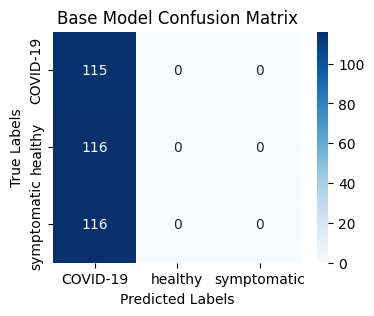


Modified Model Accuracy: 33.72%


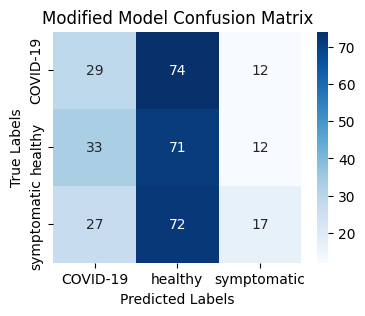

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
modified_model.to(device)

test_loader_32 = torch.utils.data.DataLoader(test_dataset, 32)
test_loader_64 = torch.utils.data.DataLoader(test_dataset, 64)

# Define a function to evaluate a model on the test set and generate a confusion matrix
def evaluate_model(model_e, test_loader, device, model_name="Model"):
  model_e.eval()
  true_labels = []
  predicted_labels = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_e(inputs)
      _, predicted = outputs.max(1)
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  # Calculate accuracy
  accuracy = accuracy_score(true_labels, predicted_labels)
  print(f"\n{model_name} Accuracy: {accuracy * 100:.2f}%")

  # Generate confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)
  class_names = le.classes_
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title(f"{model_name} Confusion Matrix")
  plt.show()

  return accuracy, cm

# Evaluate the baseline model
baseline_accuracy, baseline_cm = evaluate_model(model, test_loader_32, device, "Base Model")

# Evaluate the best version of the modified model
modified_accuracy, modified_cm = evaluate_model(modified_model, test_loader_32, device, "Modified Model")

In [ ]:
torch.cuda.empty_cache()